## Generative Adversarial Network project

In this project we train the basic *Deep Convolutional GAN* based on the architecture from the *Hands-On Machine Learning* book. The network is not exactly the same and some changes were added. We use here 4 different datasets to see how the model can perform on various types of images: animal faces, coins, landscapes and fingers. All models are deployed in the [Streamlit]() app so that one can generate images.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import cv2
import random

%matplotlib inline

All of the datasets were taken from [kaggle_coins](https://www.kaggle.com/wanderdust/coin-images), [kaggle_landscapes](https://www.kaggle.com/arnaud58/landscape-pictures), [kaggle_animals](https://www.kaggle.com/andrewmvd/animal-faces), [kaggle_fingers](https://www.kaggle.com/koryakinp/fingers). The preprocessing of the images was very similar for all of them. First we get all the filepaths for images in the specific dataset. Then all of the images are loaded into the list and at the same time they are reshaped to the *128 x 128* size. There is a problem with this approach since for larger datasets images won't fit in the memory. We load them in order to save them as the TFRecord files later. Therefore you can just load them in chunks and it will work.

In [2]:
paths = glob.glob('landscapes_dataset/**/*.jpg', recursive=True)

In [3]:
len(paths)

4319

In [4]:
tf.random.set_seed(200)
np.random.seed(200)

In [9]:
random.shuffle(paths)
im_size = 128
X = [cv2.cvtColor(cv2.resize(cv2.imread(filepath), (im_size, im_size)), cv2.COLOR_BGR2RGB) for filepath in paths]

Once the images are loaded we have to normalize them to the *0 - 1* range and also rescale to the *-1* to *1* range which corresponds to the *tanh* activation function range used in the network. 

In [11]:
X = np.array(X).astype(np.float32) / 255
X = X * 2 - 1

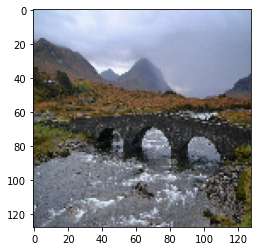

In [17]:
plt.imshow((X[165] + 1) / 2)

Now we have to store the dataset in TFRecord files. Such files contain objects which are the serialized protocol buffers. Same functions were used in the other project [github](https://github.com/twrzeszcz/image-classification-segmentation) and were explained there so we won't go into details here.

In [18]:
dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(len(X))

In [19]:
BytesList = tf.train.BytesList
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

def create_example(image):
    image_data = tf.io.serialize_tensor(image)
    return Example(features=Features(
            feature={
                'image': Feature(bytes_list=BytesList(value=[image_data.numpy()])),
            }))

In [20]:
from contextlib import ExitStack

def write_tfrecords(dataset, name, n_shards=5):
    dirpath = 'tf_records_gans_{}'.format(name)
    paths = [dirpath + '/' + "tfrecord-{:05d}-of-{:05d}".format(index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, image in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image)
            writers[shard].write(example.SerializeToString())
    return paths

In [22]:
train_filepaths = write_tfrecords(dataset, 'landscapes')

In [23]:
def preprocess(tfrecord):
    feature_descriptions = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example['image'], out_type=tf.float32)
    return image

In [24]:
def prep_dataset(filepaths, n_read_threads=6, shuffle_buffer_size=None,
                n_parse_threads=6, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset.prefetch(1)

The purpose of storing images in the TFRecord files is to efficiently load them during training which was done in the Colab. I have tested if simple loading from the drive will work but it was very slow and storing images in TFRecord files was much better solution.

In [27]:
train_set = prep_dataset(train_filepaths, shuffle_buffer_size=10000)

In [172]:
sample_im = [i for i in train_set.take(1)]

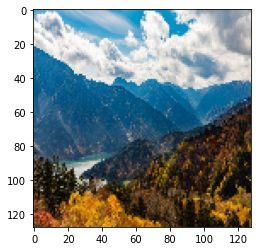

In [173]:
plt.imshow((sample_im[0][0] + 1) / 2)

Before creating a model we can define a function which will print generated images after every epoch so we can see the progress that the model is making.

In [177]:
def plot_images(images, type_data=None, n_cols=None):
    n_rows = len(images) / n_cols
    plt.figure(figsize=(15, 10))
    if type_data == 'preprocessed':
        for index, image in enumerate(images):
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow((image + 1) / 2)
            plt.axis('off')
    else:
        for index, image in enumerate(images):
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(image)
            plt.axis('off')

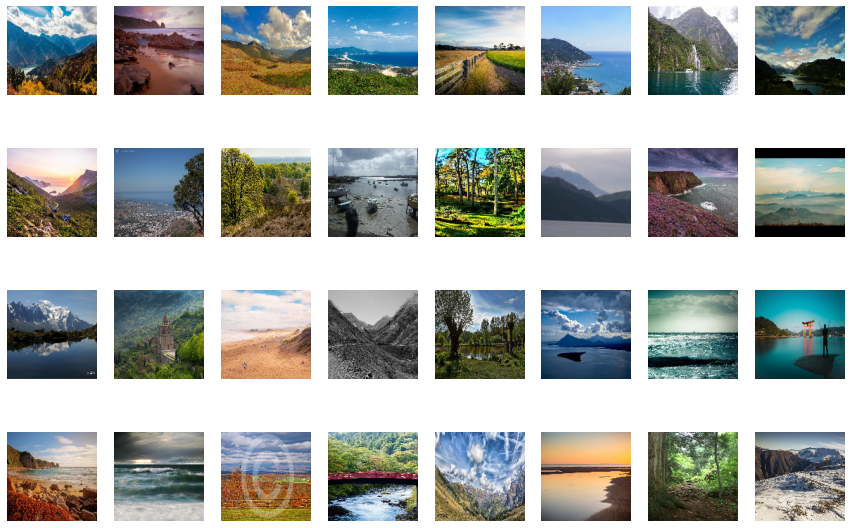

In [178]:
plot_images(sample_im[0], type_data='preprocessed', n_cols=8)

Now lets create a model. In the GAN architecture we have to distinguish a generator and a discriminator. Generator is trained to produce the best possible fake images which can fool the discriminator. So in the first step we train the discriminator with the batch of images which are the concatenated fake images generated by the generator from noise and the real images. We have to create labels for them which are just 0 for fake and 1 for real. Therefore in this step it is just a binary classification problem. Next step we train the generator and the discriminator is set to be *not trainable*. Images are again generated from noise but now we label all of them as real and feed to the discriminator.

The generator takes gaussian noise of some size and then at every step an upsampling to the desired image size is done in the Conv2DTranspose layers due to the stride of 2. In the discriminator there are just standard Conv2D layers used and due to the stride of 2 images are downsampled at every step. As it was mentioned at the beginning, the architecture was adapted from the book with all activation functions and order of layers. I have only changed the codings size from 100 to 300 and added one more Conv2D layer which does not change the size of images. However, it was not working for all of the datasets (no progress in training) so then the base model was used.

In [52]:
codings_size = 300
batch_size = 32

generator = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([16, 16, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same', activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

Only the discriminator is compiled cause it is trained in the first step. The generator is trained through the gan so that it does not have to be compiled. Also we have to make the discriminator non trainable for the second step.

In [53]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [54]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32768)             9863168   
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        204864    
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 64)       

In [55]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)      

Training is done in the custom loop cause we have to iterate over images and concatenate them with noise. All of the steps were explained above. They are done for every batch in the dataset in each epoch. Training was done on the Google Colab for 50 epochs on coins and fingers datasets, 80 epochs on animals and 200 epochs on lanscapes.

In [179]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch + 1, n_epochs))
        for X_batch in dataset:
            #train discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            #train generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
        plot_images(generated_images, type_data='preprocessed', n_cols=8)
        plt.show()

In [ ]:
train_gan(gan, train_set, batch_size, codings_size)

In [180]:
trained_gans = {'landscapes': keras.models.load_model('gan_landscapes'),
               'fingers': keras.models.load_model('gan_fingers'),
               'coins': keras.models.load_model('gan_2_coins'),
               'animals': keras.models.load_model('gan_animals')}

In [219]:
noise_0 = tf.random.normal(shape=[batch_size, 100])
noise_1 = tf.random.normal(shape=[batch_size, 300])

In [182]:
sampled_images = {}

for name in ['landscapes', 'fingers', 'coins', 'animals']:  
    paths = glob.glob('{}_dataset/**/*.jpg'.format(name), recursive=True) or glob.glob('{}_dataset/**/*.png'.format(name), recursive=True) 
    random.shuffle(paths)
    sampled_images[name] = [cv2.cvtColor(cv2.resize(cv2.imread(filepath), (im_size, im_size)), cv2.COLOR_BGR2RGB) for filepath in paths[:batch_size]]

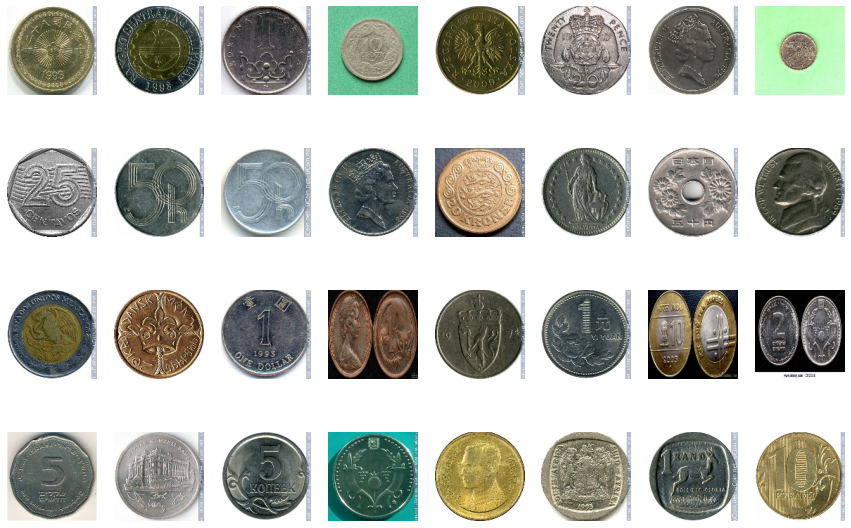

--------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------


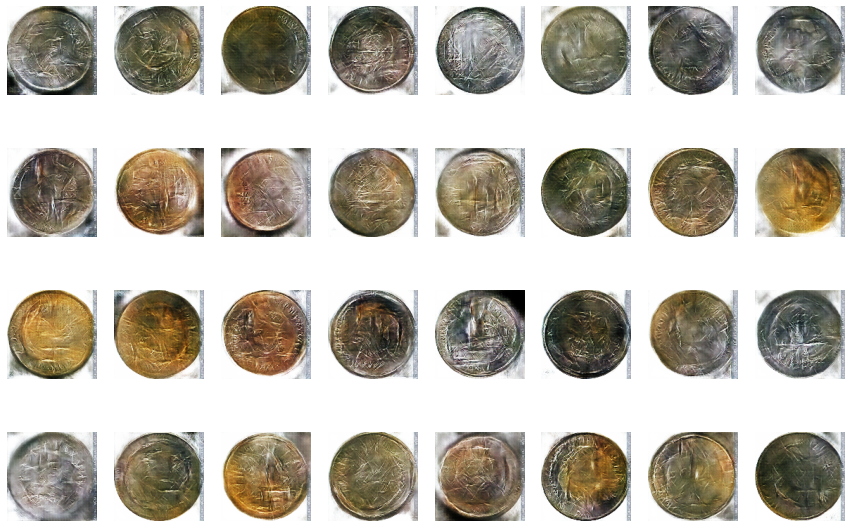

In [220]:
plot_images(sampled_images['coins'], n_cols=8)
plt.show()
print('-' * 110)
print('-' * 110)
pred = trained_gans['coins'](noise_1)
plot_images(pred, type_data='preprocessed', n_cols=8)

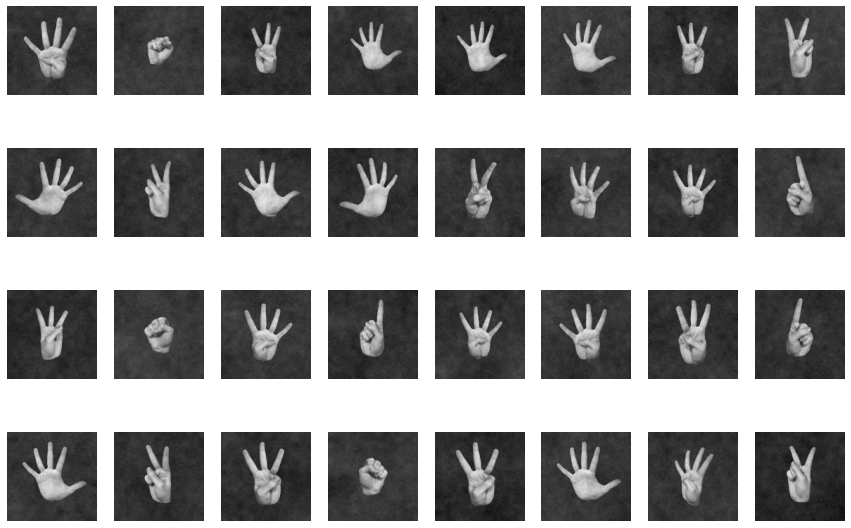

--------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------


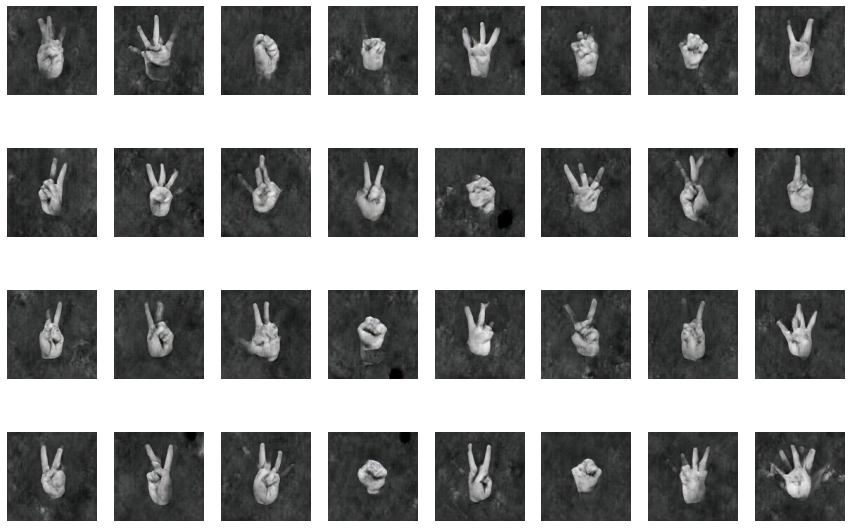

In [194]:
plot_images(sampled_images['fingers'], n_cols=8)
plt.show()
print('-' * 110)
print('-' * 110)
pred = trained_gans['fingers'](noise_0)
plot_images(pred, type_data='preprocessed', n_cols=8)

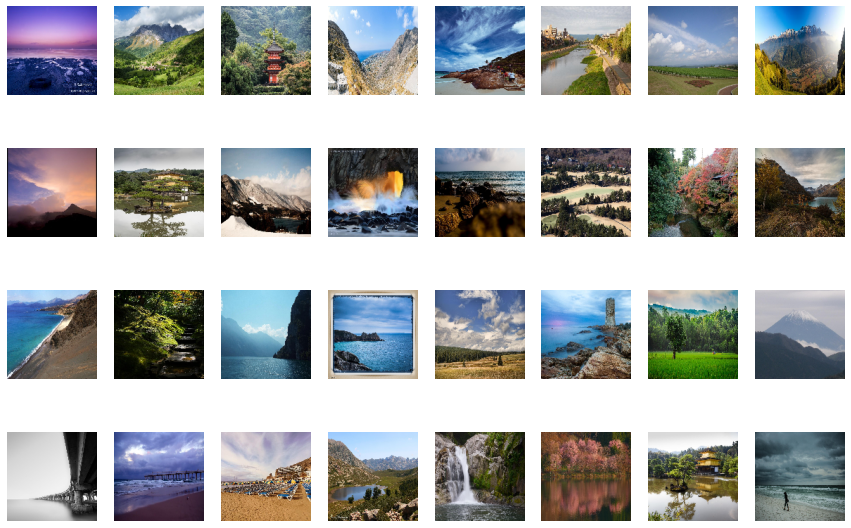

--------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------


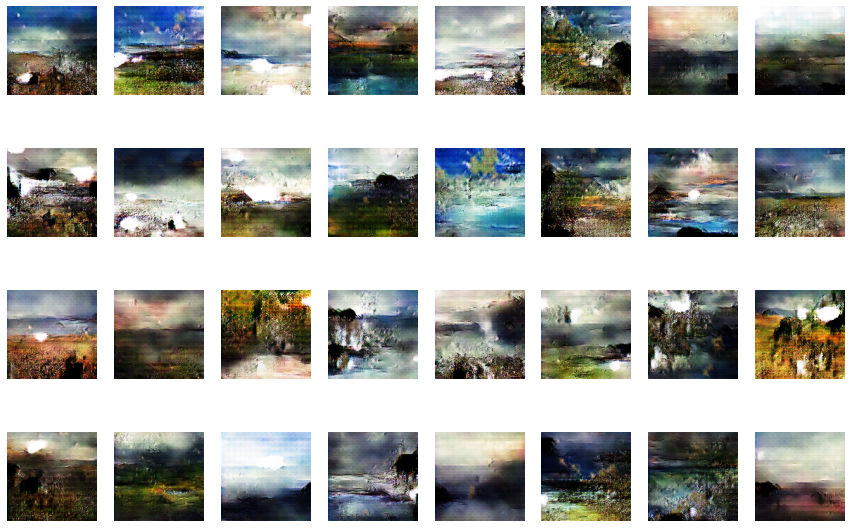

In [196]:
plot_images(sampled_images['landscapes'], n_cols=8)
plt.show()
print('-' * 110)
print('-' * 110)
pred = trained_gans['landscapes'](noise_1)
plot_images(pred, type_data='preprocessed', n_cols=8)

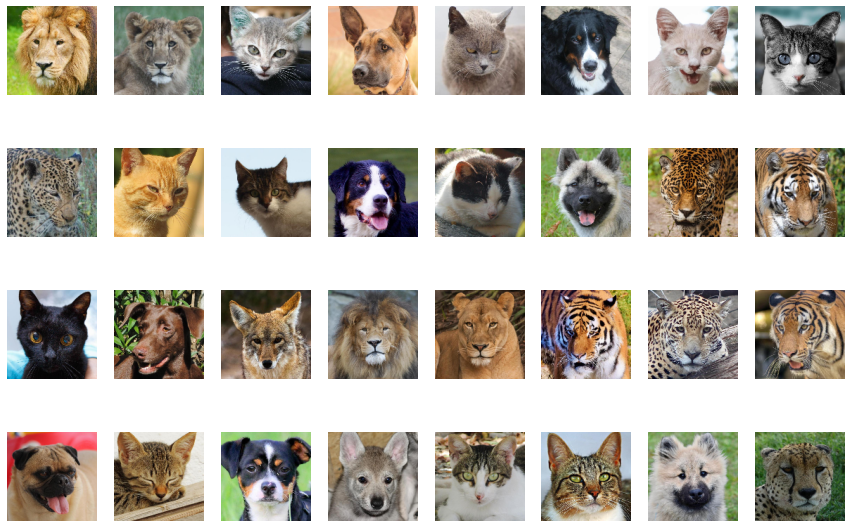

--------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------


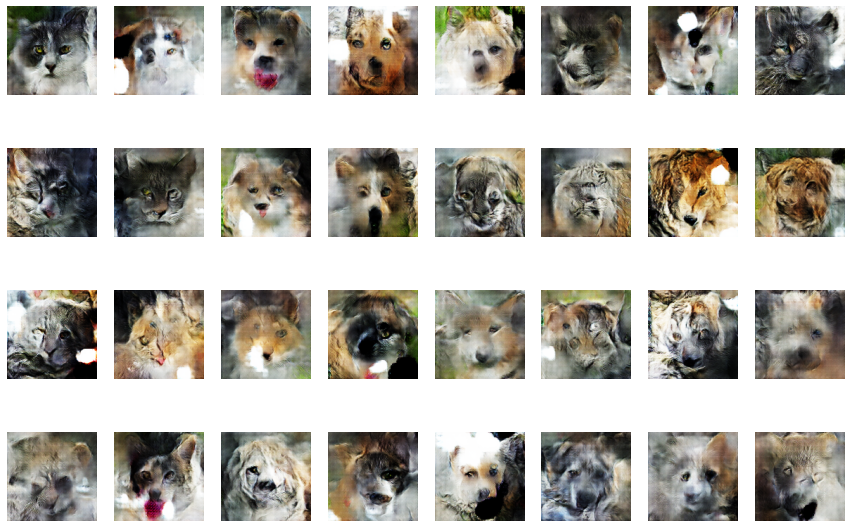

In [197]:
plot_images(sampled_images['animals'], n_cols=8)
plt.show()
print('-' * 110)
print('-' * 110)
pred = trained_gans['animals'](noise_0)
plot_images(pred, type_data='preprocessed', n_cols=8)

Generated images are not perfect but some of them somehow resemble the original ones. Especially for fingers it worked quite good. Landscapes look more like paintings than images. There is a lot of room for the improvement on the animals and landscapes datasets. Since the training was already very long I was not experimenting so much with different hyperparameters of the network.